#### CSCA 5642 Introduction to Deep Learning
# CNN Cancer Detection Kaggle Mini-Project

***

### Project Summary
The objective of this competition is **to detect the presence of metastatic cancer in small image patches taken from larger digital pathology scans**. This is a critical problem in medical diagnostics, as early detection of cancer can significantly improve treatment outcomes. 

This project is an assignment of Week 3 in the class that I'm taking, Introduction to Deep Learning.

### Data Source
The data is gathered from [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/data).

The dataset includes training and test sets. The training data consists of **220,025 images, each sized 96x96 pixels, accompanied by corresponding labels: '0' for no cancer and '1' for cancer**. These images are extracted from larger whole slide images and are stored in TIFF format. The test data comprises a set of images without labels, which will be used to evaluate the model's performance. The images are small patches of tissue, with each patch representing a different region of a slide, making the dataset diverse in terms of tissue structures and staining variations.

### Evaluation
The primary evaluation metric for this competition is the Area Under the ROC Curve (AUC), which measures the model's ability to distinguish between cancerous and non-cancerous images.

Let's create a notebook for the Kaggle competition to examine the provided files.

In [1]:
import os
print(os.listdir('/kaggle/input/histopathologic-cancer-detection'))

['sample_submission.csv', 'train_labels.csv', 'test', 'train']


***
# EDA (Exploratory Data Analysis)

Let's do EDA for finding unexpected discoveries and clean it for accurate analysis.

In [2]:
# Import Libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

In [3]:
# Constants
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3
BASE_DIR = '/kaggle/input/histopathologic-cancer-detection'
TRAIN_LABEL_PATH = f"{BASE_DIR}/train_labels.csv"
TRAIN_IMAGE_PATH = f"{BASE_DIR}/train"
TEST_IMAGE_PATH = f"{BASE_DIR}/test"

# Load data
df_train_all = pd.read_csv(TRAIN_LABEL_PATH)
df_train_all.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
df_train_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


We observe that the **dataset consists of 220,025 labeled images with no missing values**.

To clarification, let's plot the class distribution to understand more.

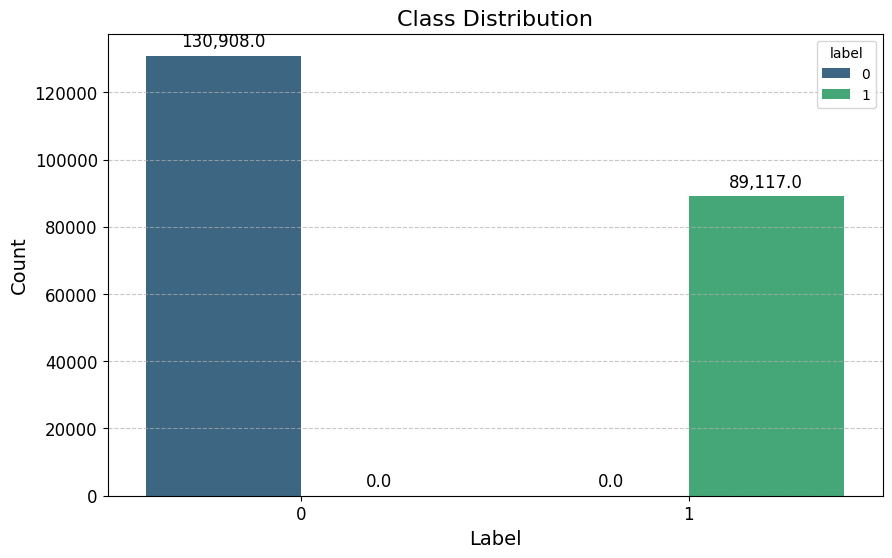

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df_train_all, palette='viridis', hue='label')
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add labels on top of the bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():,}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', 
                       fontsize=12, color='black', 
                       xytext=(0, 10), 
                       textcoords='offset points')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

As you see the plot above, the lable data has around 130K numbers of non-cancerous (0) and 89K numbers of cancerous (1) images.

For further investigating of the data, **we will visualize a few sample images from each class**.

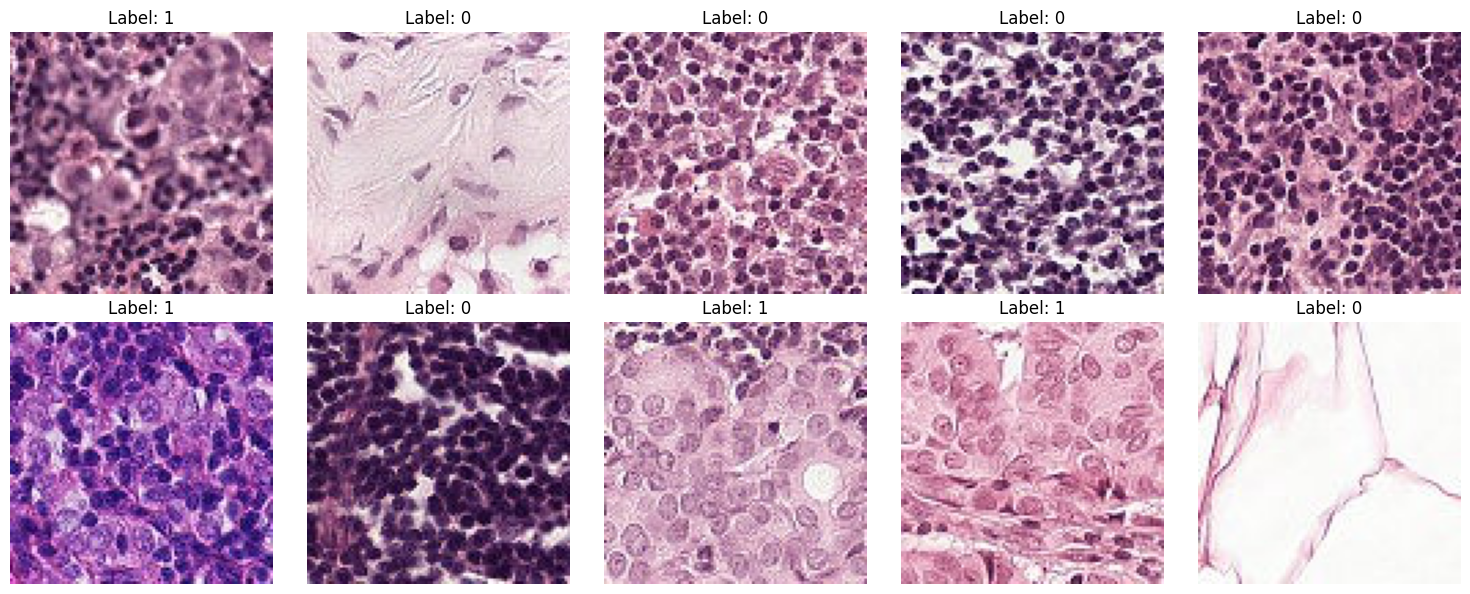

In [6]:
from PIL import Image

def show_images(image_ids, labels, ncols=5):
    nrows = len(image_ids) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3))
    for ax, img_id in zip(axes.flatten(), image_ids):
        img_path = f'{TRAIN_IMAGE_PATH}/{img_id}.tif'
        image = Image.open(img_path)
        ax.imshow(image)
        ax.set_title(f'Label: {labels.loc[labels.id == img_id, "label"].values[0]}')
        ax.axis('off')
    plt.tight_layout()

# Display sample images
sample_ids = df_train_all.sample(10)['id'].values
show_images(sample_ids, df_train_all)


# Plan of analysis
Based on our exploratory data analysis we did so far, the plan for analysis includes:

- We are going to use Pytorch Dataset to load the data gradually as the images are too many. 
- Model Building: Construct a Convolutional Neural Network (CNN) to classify the images.
- Model Training: Train the model using the dataset.
- Evaluation: Evaluate the model performance

By following this plan, we aim to build a robust model capable of accurately detecting metastatic cancer in histopathologic images.

# Train model and prediction

We start creating the CancerDataset class which can be used among training, validation and test dataset. This class handles the loading of images and labels from the dataset. It inherits from torch.utils.data.Dataset and implements the __len__ and __getitem__ methods.

We then define a convolutional neural network (CNN) model for cancer detection using PyTorch. We start by calculating the output dimensions of convolutional layers and creating the `CNNModel` class, which includes four convolutional layers with `ReLU` activation and max pooling, followed by two fully connected layers with dropout for regularization. The model parameters, such as input shape, initial filters, and dropout rate, are specified, and the model is moved to a GPU if available. We use the `Adam` optimizer and a learning rate scheduler to adjust the learning rate based on validation loss. The training process is handled by the train_val function, which trains and validates the model, saving the best model weights and tracking the training history.

In [7]:
from PIL import Image
from torch.utils.data import Dataset
import torch

torch.manual_seed(0) # fix random seed

class CancerDataset(Dataset):
    
    def __init__(self, data_dir, transform, data_type="train"):
        self.data_dir = data_dir
        self.data_type = data_type
        self.transform = transform
        self.label_file = "train_labels.csv" if data_type=="train" else "sample_submission.csv"

        # Get Image File Names
        dataset_dir = os.path.join(data_dir, data_type)
        self.file_names = os.listdir(dataset_dir)
        self.full_file_paths = [os.path.join(dataset_dir, f) for f in self.file_names]

        # Get Labels
        labels_file = os.path.join(data_dir, self.label_file)
        labels_df = pd.read_csv(labels_file)
        labels_df.set_index("id", inplace=True)
        
        # Extract labels for selected file names
        self.labels = [labels_df.loc[os.path.splitext(filename)[0]].values[0] for filename in self.file_names]

    def __len__(self):
        return len(self.full_file_paths)

    def __getitem__(self, idx):
        # Open image, apply transforms, and return with label
        image = Image.open(self.full_file_paths[idx])
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

We then define a transformation pipeline to convert images to tensors.

In [8]:
# The transform function
import torchvision.transforms as transforms
image_to_tensor_transformer = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Resize((46,46))
])

We initialize the dataset and create data loaders for training and validation sets.

In [9]:
cancer_dataset = CancerDataset(BASE_DIR, image_to_tensor_transformer)

In [10]:
# Check example tensor
img,label=cancer_dataset[10]
img.shape,torch.min(img),torch.max(img)

(torch.Size([3, 96, 96]), tensor(0.), tensor(1.))

In [11]:
from torch.utils.data import random_split

# Calculate dataset lengths
total_images = len(cancer_dataset)
train_size = int(0.8 * total_images)
val_size = total_images - train_size

# Split dataset into training and validation sets
train_dataset, val_dataset = random_split(cancer_dataset, [train_size, val_size])

# Print dataset sizes
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))


Training dataset size: 176020
Validation dataset size: 44005


In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset,
                      batch_size=32, 
                      shuffle=True)

val_loader = DataLoader(val_dataset,
                    batch_size=32,
                    shuffle=False)


Finally, we define a CNN model class, specifying the structure of the network.

In [13]:
import torch.nn as nn
import torch.nn.functional as F

def find_conv2d_out_shape(height, width, conv_layer, pool=2):
    """Calculate the output shape of a Conv2D layer with optional pooling."""
    kernel_size = conv_layer.kernel_size
    stride = conv_layer.stride
    padding = conv_layer.padding
    dilation = conv_layer.dilation

    height_out = np.floor((height + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
    width_out = np.floor((width + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)

    if pool:
        height_out /= pool
        width_out /= pool

    return int(height_out), int(width_out)

class CNNModel(nn.Module):
    """Neural Network with Conv2D and Fully Connected layers."""
    
    def __init__(self, params):
        super(CNNModel, self).__init__()
        
        # Extract parameters
        channels_in, height_in, width_in = params["shape_in"]
        initial_filters = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]
        
        # Define convolutional layers
        self.conv1 = nn.Conv2d(channels_in, initial_filters, kernel_size=3)
        height, width = find_conv2d_out_shape(height_in, width_in, self.conv1)
        
        self.conv2 = nn.Conv2d(initial_filters, 2 * initial_filters, kernel_size=3)
        height, width = find_conv2d_out_shape(height, width, self.conv2)
        
        self.conv3 = nn.Conv2d(2 * initial_filters, 4 * initial_filters, kernel_size=3)
        height, width = find_conv2d_out_shape(height, width, self.conv3)
        
        self.conv4 = nn.Conv2d(4 * initial_filters, 8 * initial_filters, kernel_size=3)
        height, width = find_conv2d_out_shape(height, width, self.conv4)
        
        # Compute the flattened size
        self.num_flatten = height * width * 8 * initial_filters
        
        # Define fully connected layers
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, x):
        """Forward pass through the network."""
        # Convolution and pooling layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten the tensor
        x = x.view(-1, self.num_flatten)
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout_rate)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

We define the parameters for the CNN model and move the model to the GPU if available.

In [14]:
# Parameters
params_model={
        "shape_in": (3,96,96), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

cnn_model = CNNModel(params_model)

# Hardware settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = cnn_model.to(device)

In [16]:
loss_func = nn.NLLLoss(reduction="sum")

In [17]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim

optimizer = optim.Adam(cnn_model.parameters(), lr=3e-4)

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 10,
 "optimizer": optimizer,
 "lr_change": ReduceLROnPlateau(optimizer,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

We define the training and validation loop and train the model using the specified parameters.

In [18]:
from tqdm.notebook import trange, tqdm
import copy
import torch

def train_val(model, params, verbose=False):
    # Extract parameters
    epochs = params["epochs"]
    loss_func = params["f_loss"]
    optimizer = params["optimizer"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Initialize history dictionaries and best model weights
    loss_history = {"train": [], "val": []}
    metric_history = {"train": [], "val": []}
    best_model_weights = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    def get_current_lr(optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']
    
    def loss_epoch(model, loss_func, dataloader, optimizer=None):
        running_loss = 0.0
        running_metric = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            if optimizer:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_metric += (outputs.argmax(1) == labels).sum().item()
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_metric = running_metric / len(dataloader.dataset)
        return epoch_loss, epoch_metric
    
    # Training and validation loop
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        current_lr = get_current_lr(optimizer)
        if verbose:
            print(f'Epoch {epoch}/{epochs - 1}, current lr={current_lr}')
        
        # Training phase
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, optimizer)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), weight_path)
            if verbose:
                print("Copied best model weights!")
        
        # Adjust learning rate
        lr_scheduler.step(val_loss)
        if current_lr != get_current_lr(optimizer):
            if verbose:
                print("Loading best model weights!")
            model.load_state_dict(best_model_weights)
        
        if verbose:
            print(f"train loss: {train_loss:.6f}, val loss: {val_loss:.6f}, accuracy: {100 * val_metric:.2f}%")
            print("-" * 10)
    
    # Load best model weights
    model.load_state_dict(best_model_weights)
    
    return model, loss_history, metric_history


In [19]:
cnn_model, loss_hist ,metric_hist=train_val(cnn_model, params_train)

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

We plot the training and validation loss and accuracy over epochs.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

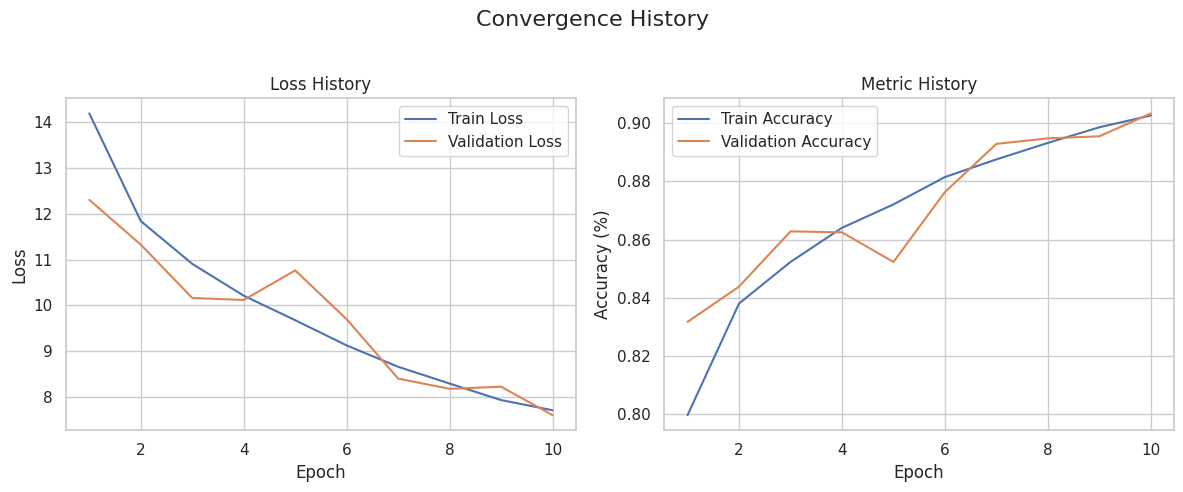

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set(style='whitegrid')

# Extract the number of epochs
epochs = params_train["epochs"]

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss history
sns.lineplot(x=range(1, epochs + 1), y=loss_hist["train"], ax=ax[0], label='Train Loss')
sns.lineplot(x=range(1, epochs + 1), y=loss_hist["val"], ax=ax[0], label='Validation Loss')
ax[0].set_title('Loss History')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot metric history
sns.lineplot(x=range(1, epochs + 1), y=metric_hist["train"], ax=ax[1], label='Train Accuracy')
sns.lineplot(x=range(1, epochs + 1), y=metric_hist["val"], ax=ax[1], label='Validation Accuracy')
ax[1].set_title('Metric History')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()

# Set the main title
fig.suptitle('Convergence History', fontsize=16)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


We initialize the test dataset and print the number of test samples.

In [21]:
cancer_dataset_test = CancerDataset(BASE_DIR, image_to_tensor_transformer, data_type='test')
print(len(cancer_dataset_test))

57458


We define a function to perform inference on the test dataset and then use this function to make predictions.

In [22]:
def inference(model, dataset, device, num_classes=2):
    len_data = len(dataset)
    y_out = torch.zeros(len_data, num_classes, device=device)  # initialize output tensor on device
    y_gt = np.zeros(len_data, dtype="uint8")  # initialize ground truth

    model = model.to(device)  # move model to device

    with torch.no_grad():
        for i in tqdm(range(len_data), desc="Inference Progress"):
            x, y = dataset[i]
            y_gt[i] = y
            y_out[i] = model(x.unsqueeze(0).to(device))

    return y_out.cpu().numpy(), y_gt

# Perform inference
y_test_out, _ = inference(cnn_model, cancer_dataset_test, device)

# Class predictions (0, 1)
y_test_pred = np.argmax(y_test_out, axis=1)
print(y_test_pred.shape)
print(y_test_pred[:5])

# Probabilities of predicted class
preds = np.exp(y_test_out[:, 1])
print(preds.shape)
print(preds[:5])

Inference Progress:   0%|          | 0/57458 [00:00<?, ?it/s]

(57458,)
[0 0 0 0 0]
(57458,)
[0.21307972 0.10429065 0.12060036 0.29408816 0.2375476 ]


In [23]:
cancer_dataset_test.file_names[0]

'a7ea26360815d8492433b14cd8318607bcf99d9e.tif'

# Submission

For submittion, let's write a .csv file with id and updated lables.

In [24]:
import pandas as pd

# Assuming img_dataset_test has a method to get ids or filenames
# This is a mock function to simulate getting IDs from the dataset
def get_image_ids(dataset):
    file_names= dataset.file_names
    return [file_names[i].split('.')[0] for i in range(len(file_names))]

# Get the image IDs
image_ids = get_image_ids(cancer_dataset_test)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    "id": image_ids,
    "label": preds
})

# Write the results to a CSV file
results_df.to_csv('submission.csv', index=False)

In [25]:
results_df

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.213080
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.104291
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.120600
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.294088
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.237548
...,...,...
57453,7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b,0.050174
57454,2a6fc1ed16fa94d263efab330ccbeb1906cbd421,0.208144
57455,6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14,0.968351
57456,f11e7c9e77cbc1ec916a52e6b871a293ee1bb928,0.000897
